In [8]:
import sys
import glob
import xarray as xr
import pandas as pd
import numpy as np

processing_mode = 'delayed' # delayed or realtime
deployment = 'batray_20230317'
nc_path = './../glider_data/'+deployment+'/'+processing_mode+'/nc/'
traj_file_name = sorted(glob.glob(nc_path + '*{}*.nc'.format('trajectory')))
with xr.open_dataset(traj_file_name[0], engine='netcdf4', decode_times=False) as ds:
    data = ds.sortby('time').to_dataframe().reset_index()
with xr.open_dataset(traj_file_name[0], engine='netcdf4', group='glider_record', decode_times=False) as ds:
    raw_data = ds.sortby('time').to_dataframe().reset_index()


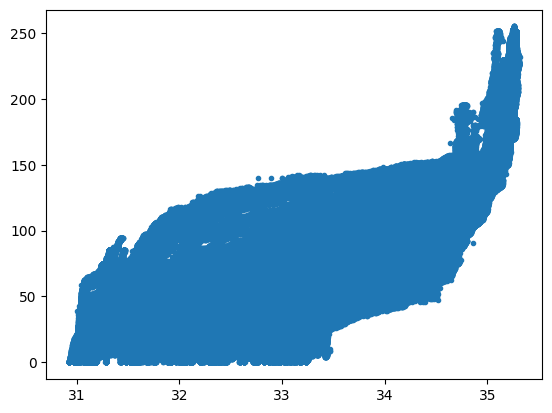

In [38]:
plt.plot(data['salinity'],data['depth'],'.')

In [9]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from datetime import datetime

# convert timestamps to datetime objects
time = [datetime.fromtimestamp(ts) for ts in data['time']]

# sub-sample the time list to reduce the number of ticks
n_ticks = 10
step = len(time) // n_ticks
time_ticks = time[::step]

In [10]:
import pandas as pd
import erddapClient
print("Pandas version:", pd.__version__)
print("erddapClient version:", erddapClient.__version__)

Pandas version: 1.5.3
erddapClient version: 1.0.0


In [11]:
# Load Bathymetry data
from erddapClient import ERDDAP_Griddap
remote = ERDDAP_Griddap('https://pae-paha.pacioos.hawaii.edu/erddap/', 'srtm30plus_v11_bathy')

topo_variable = ['elev']
remote.setResultVariables(topo_variable)

lat1,lat2 = np.nanmin(data['lat']),np.nanmax(data['lat'])
lon1,lon2 = np.nanmin(data['lon']),np.nanmax(data['lon'])
print(lat1,lat2,lon1,lon2)

# Set the subset for the desired region and time
bathy_data = remote.setSubset(
    latitude=slice(lat1-0.1, lat2+0.1),
    longitude=slice(lon1, lon2)
).getxArray()
bathy_data = bathy_data.fillna(0)

# Extract the data from the xarray
bathy = bathy_data['elev'].values

# Extract the latitude and longitude coordinates
latitude = bathy_data['latitude'].values
longitude = bathy_data['longitude'].values

# Create a meshgrid from the latitude and longitude coordinates
lon_grid, lat_grid = np.meshgrid(longitude, latitude)

42.93545000000001 44.387433333333334 -63.395505 -62.09618666666667


/Users/research/.pyenv/versions/3.11.3/lib/python3.11/site-packages/erddapClient/erddap_griddap_dimensions.py:196: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  idx = self.values.index.get_loc(value, method=method)
/Users/research/.pyenv/versions/3.11.3/lib/python3.11/site-packages/erddapClient/erddap_griddap_dimensions.py:196: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  idx = self.values.index.get_loc(value, method=method)
/Users/research/.pyenv/versions/3.11.3/lib/python3.11/site-packages/erddapClient/erddap_griddap_dimensions.py:196: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  idx = self.values.index.get_loc(value, method=method)
/Users/research/.pyenv

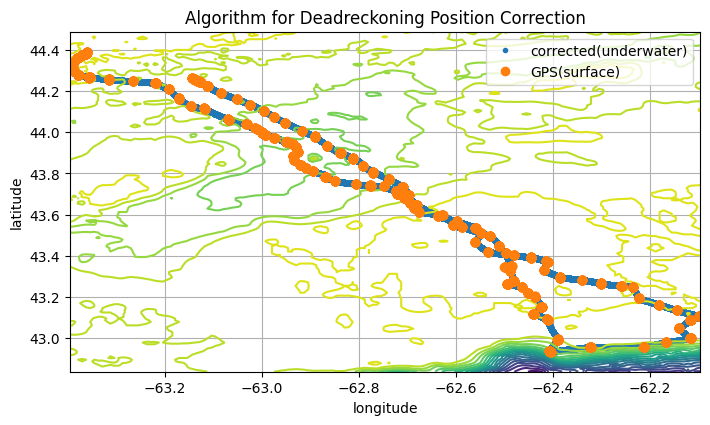

In [13]:
# Track Plot Map
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(data['lon_qc'],data['lat_qc'],'.',label='corrected(underwater)')
contour = ax.contour(lon_grid, lat_grid, bathy, levels=20)

ax.plot(raw_data['m_gps_lon'],raw_data['m_gps_lat'],'o',label='GPS(surface)')
ax.set(xlabel='longitude', ylabel='latitude',
       title='Algorithm for Deadreckoning Position Correction')
ax.grid()
ax.legend()
fig.patch.set_facecolor('white')
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.95)

fig.savefig(processing_mode+'_track.png', dpi=100, bbox_inches='tight')

(0.0, 12.0)

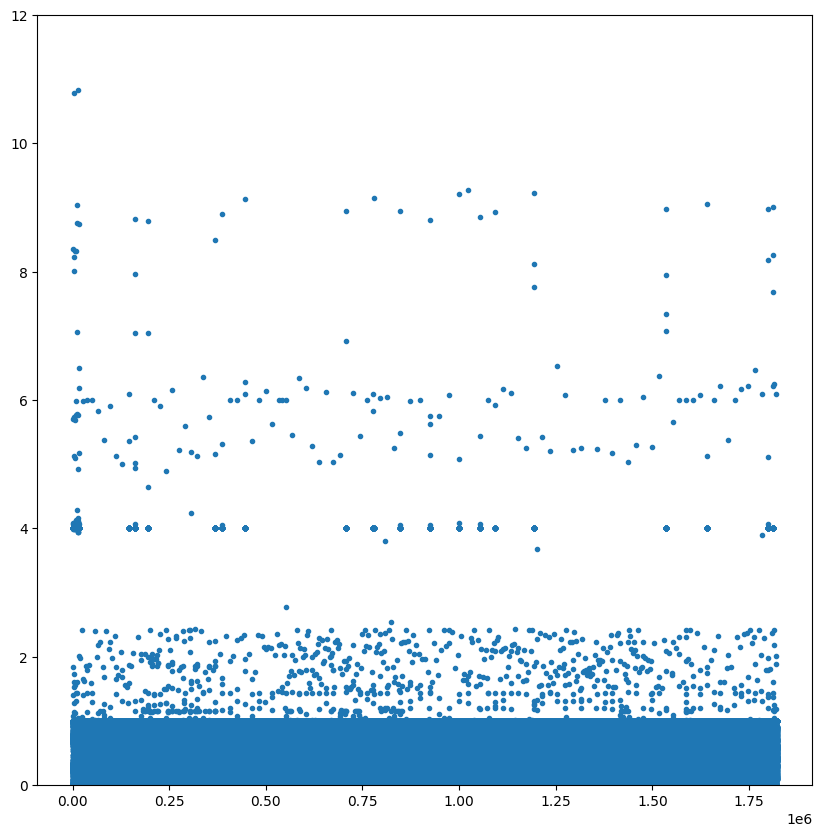

In [14]:
# Sampling period
fig, axs = plt.subplots(1,1, figsize=(10, 10))
axs.plot( np.diff(data['time'].values),'.')
axs.set_ylim(0,12)

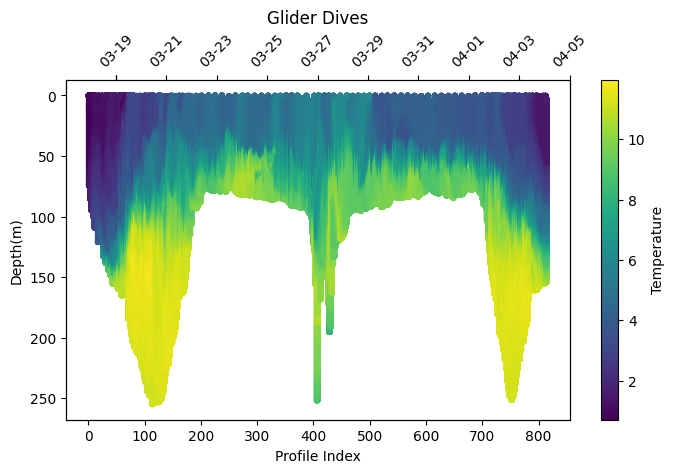

In [15]:
# plotting the temperature time/depth figure
fig, ax = plt.subplots(figsize=(7,4))
sc = ax.scatter(data['profile_index'], data['depth'], c=data['temperature'], cmap='viridis', s=10)
plt.colorbar(sc, label='Temperature')
ax.set(xlabel='Profile Index', ylabel='Depth(m)', title='Glider Dives')
ax.invert_yaxis()

# format the x-axis to display the profile index as an integer
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.0f}'))

# add second x-axis for time stamps
ax2 = ax.twiny()
ax2.set_xlabel('')
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(ax.get_xticks())
ax2.set_xticklabels([t.strftime('%m-%d') for t in time_ticks])

# set the first x-tick of the time axis to match the first profile index
start_time = time[0].replace(hour=0, minute=0, second=0)
start_profile = data['profile_index'][0]
offset = (start_time - time[0]).total_seconds() / 3600 / 24
ax2.set_xticks([start_profile, start_profile+offset]+list(ax.get_xticks())[1:])

# rotate the x-axis tick labels
plt.xticks(rotation=45)

# setting background color to white and reducing padding
fig.patch.set_facecolor('white')
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.95, wspace=0.2)
fig.savefig(processing_mode+'_temperature.png', dpi=100, bbox_inches='tight')